### Consider the following loan specifics:

- Mortgage type: conventional fixed rate mortgage
- Duration: 30 years
- Nominal interest rate: 4.000% per annum
- Pay period: monthly
- Amount: $250,000


In [184]:
# Imports for plotting
%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.dpi"] = 80
import matplotlib.pyplot as plt
import numpy as np

PRINCIPAL = 250000
NOMINAL_INTEREST_RATE = 0.04
COMPOUNDING_FREQUENCY = 12
LOAN_DURATION = 30

In [185]:
def compound_interest(principal, rate_per_period, num_periods):
    return (
        principal * (pow(1 + rate_per_period, num_periods) - 1)
    )

class SimpleMortgage(object):
    def __init__(self, principal=PRINCIPAL, rate=NOMINAL_INTEREST_RATE, frequency=COMPOUNDING_FREQUENCY, duration=LOAN_DURATION):
        self.starting_principal = float(principal)
        self.annual_rate = float(rate)
        self.compounding_frequency = int(frequency)
        self.duration = int(duration)
        
        # Store often-used intermediate values
        self.alpha = self.annual_rate / self.compounding_frequency
        self.num_payments = self.duration * self.compounding_frequency
        
    def iter_periods(self):
        for period in range(1, self.num_payments + 1):
            yield period
    
    @property
    def monthly_payment(self):
        return (
            (self.alpha * self.starting_principal) / 
            (1 - pow(1 + self.alpha, -self.num_payments))
        )
    
    def principal_for_pay_period(self, period):
        if period < 1:
            raise ValueError("Cannot compute principals before pay period 1.")
        return (
            (self.starting_principal * pow(1 + self.alpha, period - 1)) -
            (self.monthly_payment * (pow(1 + self.alpha, period - 1) - 1) / self.alpha)
        )
    
    def schedule_for_pay_period(self, period):
        interest = compound_interest(
            self.principal_for_pay_period(period), self.alpha, 1
        )
        principal = self.monthly_payment - interest
        return (principal, interest)
    
    def outstanding_after_pay_period(self, period):
        # This is equal to the principal for the following pay period.
        return self.principal_for_pay_period(period + 1)

In [187]:
# Initialize mortgage object
mortgage = SimpleMortgage()
print("Monthly mortgage payment = ${:.2f}".format(mortgage.monthly_payment))

Monthly mortgage payment = $1193.54


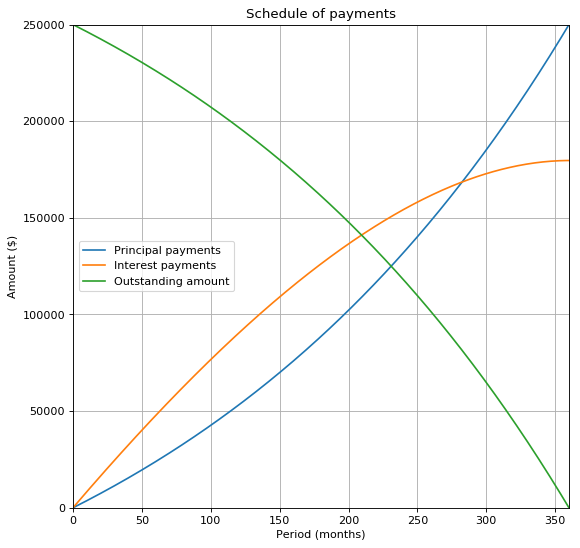

In [189]:
# Compute period-end stats
period, paid_up_principal, paid_up_interest, outstanding_amount = [0], [0], [0], [mortgage.starting_principal]
for pdnum in mortgage.iter_periods():
    period_principal, period_interest = mortgage.schedule_for_pay_period(pdnum)
    period.append(pdnum)
    paid_up_principal.append(paid_up_principal[-1] + period_principal)
    paid_up_interest.append(paid_up_interest[-1] + period_interest)
    outstanding_amount.append(mortgage.outstanding_after_pay_period(pdnum))

# Plot accruals
plt.title("Schedule of payments")
plt.plot(period, paid_up_principal, label="Principal payments")
plt.plot(period, paid_up_interest, label="Interest payments")
plt.plot(period, outstanding_amount, label="Outstanding amount")
plt.xlabel("Period (months)")
plt.xlim([0, 360])
plt.ylabel("Amount ($)")
plt.ylim([0, 250000])
plt.grid()
plt.legend()
plt.show()

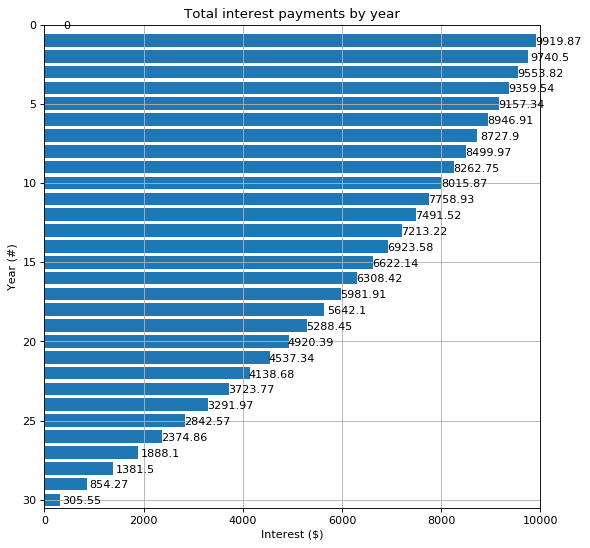

In [190]:
# Total interest payments per year
year_num, interest_per_year = [0], [0]
cumulative_interest = 0
for period in mortgage.iter_periods():
    period_principal, period_interest = mortgage.schedule_for_pay_period(period)
    cumulative_interest = cumulative_interest + period_interest
    if period % mortgage.compounding_frequency == 0:
        # Implies one year worth of periods have been counted
        year_num.append(period/mortgage.compounding_frequency)
        interest_per_year.append(round(cumulative_interest, 2))
        cumulative_interest = 0

# Plot annual interest payments
plt.title("Total interest payments by year")
k = plt.barh(year_num, interest_per_year,)
plt.ylabel("Year (#)")
plt.ylim([30.5, 0])
plt.xlabel("Interest ($)")
plt.xlim([0, 10000])
plt.grid()

# Add value labels
ax = plt.gca()
bars = ax.patches
for bar, label in zip(bars, interest_per_year):
    width = bar.get_width()
    ax.text(width + 450, bar.get_y() + bar.get_height(), label, ha='center', va='bottom')